# Funcomics

Here, I should run all the fun stuff & save as mudata for next chapter

## Setup Env

In [1]:
import os, fnmatch

import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sq

In [2]:
import liana as li
from liana.method.sp import lr_bivar, bivar

In [3]:
import decoupler as dc
import seaborn as sns

In [4]:
from mudata import MuData

In [5]:
data_dir = os.path.join('..', '..', 'data', 'kidney_injury', 'visium')
slides = fnmatch.filter(os.listdir(os.path.join(data_dir, "deconv")), '*.h5ad')

In [6]:
adatas = dict()

for slide in slides:
    sample = slide[:-5].split("_")[0]
    adatas[sample] = sc.read_h5ad(os.path.join(data_dir, "deconv", slide))

In [7]:
adatas

{'f12hr': AnnData object with n_obs × n_vars = 1816 × 14640
     obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'leiden'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'log1p', 'spatial'
     obsm: 'spatial', 'tangram_ct_pred'
     layers: 'counts',
 'f2dps': AnnData object with n_obs × n_vars = 2110 × 15894
     obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'leiden'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'log1p', '

#### CytoSig

In [8]:
# load cytosig signatures
cytosig = pd.read_csv("https://raw.githubusercontent.com/data2intelligence/CytoSig/master/CytoSig/signature.centroid", sep="\t")
cytosig = cytosig.unstack().reset_index().rename(columns={'level_0':'source', 'level_1':'target', 0:'weight'})
# translate to murine
cytosig = dc.translate_net(net=cytosig, target_organism="mouse", columns=["target"])

## TODO need to remove cytokine map genes from the signatures

## TODO change to OmniPath, check if consistent with og CytoSig:
# import omnipath
# from pypath.utils import mapping

# cytosig = omnipath.requests.Annotations.get(resources = 'CytoSig', wide = True)
# up_gs = mapping.translation_df('uniprot', 'genesymbol')
# # look at the ugly pandas syntax...
# cytosig = cytosig.merge(
#     up_gs,
#     left_on = ['cytokine'],
#     right_on = ['uniprot'],
#     suffixes = ('', '_y'),
# ).rename(
#     {'genesymbol_y': 'translated_cytokine_genesymbol'},
#     axis = 1,
# ).drop(
#     'uniprot_y',
#     axis = 1,
# )

#### PROGENy

In [9]:
progeny = dc.get_progeny(organism='Mus musculus', top=500)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Dorothea

In [10]:
dorothea = dc.get_dorothea(organism='mouse')

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/decoupler/omnip.py:671: UserWarning: The installed version of `omnipath` is older than 1.0.7 or 2023-05-30. To make sure CollecTRI and DoRothEA data is processed correctly, please update to the latest version by `pip install git+https://github.com/saezlab/omnipath.git`.


## Run on all samples

In [12]:
for sample in adatas.keys():
    adata = adatas[sample]
    
    # Run CytoSig
    dc.run_ulm(adata, cytosig, use_raw=False)
    adata.obsm['cytosig_estimate'] = adata.obsm['ulm_estimate']
    
    # Run PROGENy
    dc.run_ulm(adata, progeny, use_raw=False)
    adata.obsm['progeny_estimate'] = adata.obsm['ulm_estimate']
    
    # Run Dorothea
    dc.run_ulm(adata, dorothea, use_raw=False)
    adata.obsm['dorothea_estimate'] = adata.obsm['ulm_estimate']
    
    del adata.obsm['ulm_estimate']
    del adata.obsm['ulm_pvals']

## Convert to mdatas & save

In [13]:
mdatas = dict()
for sample in adatas.keys():
    # TODO allow var app to be added, add keep obsm_keys
    adata = adatas[sample].copy()
    adata.obs = adata.obs[['sample', 'leiden']]
    
    cytosig_ad = li.fun.obsm_to_adata(adata, obsm_key="cytosig_estimate")
    # cytosig_ad.var.index = 'cytosig:' + cytosig_ad.var.index
    
    progeny_ad = li.fun.obsm_to_adata(adata, obsm_key="progeny_estimate")
    progeny_ad.var.index = 'progeny:' + progeny_ad.var.index
    
    dorothea_ad = li.fun.obsm_to_adata(adata, obsm_key="dorothea_estimate")
    # dorothea_ad.var.index = 'dorothea:' + dorothea_ad.var.index
    
    tangram_ad = li.fun.obsm_to_adata(adata, obsm_key="tangram_ct_pred")
    
    mdata = MuData({'rna':adata,
                    'cytosig':cytosig_ad,
                    'progeny':progeny_ad, 
                    'dorothea':dorothea_ad, 
                    'tangram':tangram_ad}
                   )
    
    mdata.write(os.path.join(data_dir, "mdatas", sample + ".h5ad"))
    
    mdatas[sample] = mdata

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core

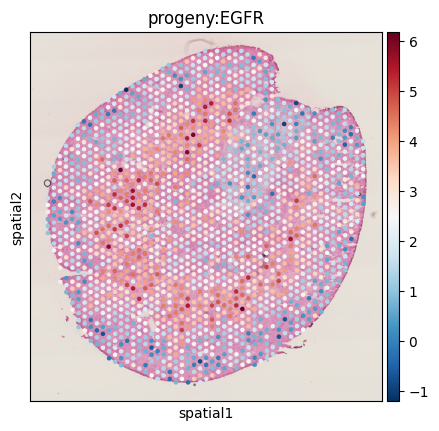

In [18]:
sc.pl.spatial(mdatas['f12hr'].mod['progeny'], color='progeny:EGFR', cmap='RdBu_r')